In [1]:
# Copyright © Advanced Micro Devices, Inc., or its affiliates.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Advanced Image Processing with hipCIM on AMD Instinct GPUs

**Note**
_hipCIM is in an early access state. Running production workloads is not recommended._

Welcome to the hipCIM demo, a brief glimpse into harnessing the full potential of hipCIM, an API-compatible alternative to CuCIM, optimized for use with AMD Instinct GPUs. hipCIM is a powerful open-source library that accelerates computer vision and image processing tasks for multidimensional images across various domains including biomedical, geospatial, and remote sensing.

## Key Features and Demonstrations

### Brief Introduction to Histopathological Whole Slide Images (WSIs)
   - ___Context Setting___: Sample WSI

### Efficient Image Loading and Metadata Exploration
   - ___Image Reading___: Use the CuImage class to load high-dimensional images efficiently into memory.
   - ___Metadata Inspection___: Access a rich set of APIs for examining image metadata, offering deep insights into image properties with ease.

### Advanced Image Manipulation
   - ___Sub-region Extraction___: Seamlessly read and extract specific sub-regions from large image datasets, with the flexibility to load data onto CPU or GPU memory.
   - ___Array Interoperability___: Convert CuImage objects into NumPy arrays using the __array_interface__, or directly load images to GPU memory using __cuda_array_interface__.

### Sophisticated Image Processing Techniques
   - ___Stain Separation___: Utilize hipCIM’s scikit-image-compatible filter API for effective stain separation in histopathological images.
   - ___Transform Interfaces___: Leverage ImageOnlyTransform and Compose from the Albumentations library for seamless image resizing, showcasing the interoperability of hipCIM with Albumentations workflows.

### GPU-Accelerated Image Segmentation, Gabor Filters and Edge Detection
   - ___Color Intensity-Based Segmentation___: Efficiently segment histopathological images by dividing tissue regions based on color intensity.
   - ___Gabor Filters___: Explore texture analysis using Gabor filters, demonstrating enhanced image feature extraction with GPU acceleration.
   - ___Edge Detection___: Implement edge detection using the Sobel filter for identifying structural components within tissue images, showcasing optimized performance via GPU.

### Performance Benefits 
Illustrate substantial performance enhancements achieved through GPU acceleration, emphasizing the speed and efficiency of processing workloads on AMD Instinct GPUs.

## Instructions for the demo
Please follow the instructions available [here]([url](https://amd.atlassian.net/wiki/spaces/DCGPUAIST/pages/956684133/Installing+hipCIM)) to 
install hipCIM and its dependencies.

## This notebook showcases the functionality made available by hipCIM
_The rest of the notebook is self-explanatory._

In [2]:
# Install additional packages required for the demo
%pip install matplotlib pillow numpy jupyter albumentations scikit-image pyvips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 17.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 106.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 111.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34/34 [jupyter]2/34 [notebook]b]server]minals]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Define some utility routines

In [3]:
import os.path
import xml.etree.ElementTree as ET 
from IPython.display import Markdown
from matplotlib import pyplot as plt

# Display markdown string
def printmd(string):
    display(Markdown(string))

# Visualize an image
def visualize(image):
    dpi = 80.0
    height, width, _ = image.shape
    plt.figure(figsize=(width / dpi, height / dpi))
    plt.axis('off')
    plt.imshow(image)

# Calculate human-friendly file size
def filesize_h(filename):
    # Get the file size in bytes
    size = os.path.getsize(filename)

    # Convert bytes to KB, or MB or GB
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0

# Remove namespace from element tags
def strip_namespace(element):
    if '}' in element.tag:  
        element.tag = element.tag.split('}', 1)[1]  
    for child in element:  
        strip_namespace(child)  

# Convert metadata XML to dict
def xml_to_dict(element):
    # Strip namespaces
    strip_namespace(element)
    
    # Convert an XML element and its children into a dict  
    data_dict = {element.tag: {} if element.attrib else None}  
    children = list(element)  
    if children:  
        dd = {}  
        for dc in map(xml_to_dict, children):  
            for k, v in dc.items():  
                if k in dd:  
                    if not isinstance(dd[k], list):  
                        dd[k] = [dd[k]]  
                    dd[k].append(v)  
                else:  
                    dd[k] = v  
        data_dict = {element.tag: dd}  
    if element.attrib:  
        data_dict[element.tag].update(('@' + k, v) for k, v in element.attrib.items())  
    if element.text:  
        text = element.text.strip()  
        if children or element.attrib:  
            if text:  
                data_dict[element.tag]['#text'] = text  
        else:  
            data_dict[element.tag] = text  
    return data_dict 

## Test Essential Matrix Estimation

Testing hipCIM's `estimate_transform` function with CuPy arrays for essential matrix estimation.

## Histopathological Whole Slide Image (WSI)


### Histopathological Whole Slide Image (WSI)

A histopathological whole slide image (WSI) is a digital version of a microscope slide that 
contains a tissue sample. It is used by pathologists to examine tissues for signs of disease, 
such as cancer. 

- ___Digitization___: Traditional glass slides are scanned using a whole slide imaging scanner to produce high-resolution digital images.
- ___High Resolution___: These images are extremely detailed, often several gigapixels in size, allowing for the examination of tissues at various magnifications.
- ___Analysis___: Pathologists examine WSIs using software to pan, zoom, and navigate through different tissue regions.
- ___Remote Access___: Digital slides enable remote consultation and sharing among specialists, improving diagnostic accuracy and collaboration.
- ___Archiving and Retrieval___: WSIs facilitate easy storage and retrieval, enhancing accessibility over physical slides.
- ___AI Applications___: The digital format allows the application of artificial intelligence and machine learning for advanced analysis, such as pattern recognition and automated diagnosis assistance.

Histopathological WSIs are transforming pathology by enhancing accessibility, enabling precise diagnosis, 
and opening up opportunities for advanced research and analysis.

**For this demo, we are going to use the following histopathological whole slide image (WSI) of a tissue 
section from a lymphoid organ such as a lymph node or tonsil.**

**It has been stained using Hematoxylin and Eosin (H&E), which is commonly used in pathology to 
differentiate cell nuclei (purple/blue) and cytoplasmic or extracellular components (pink).**



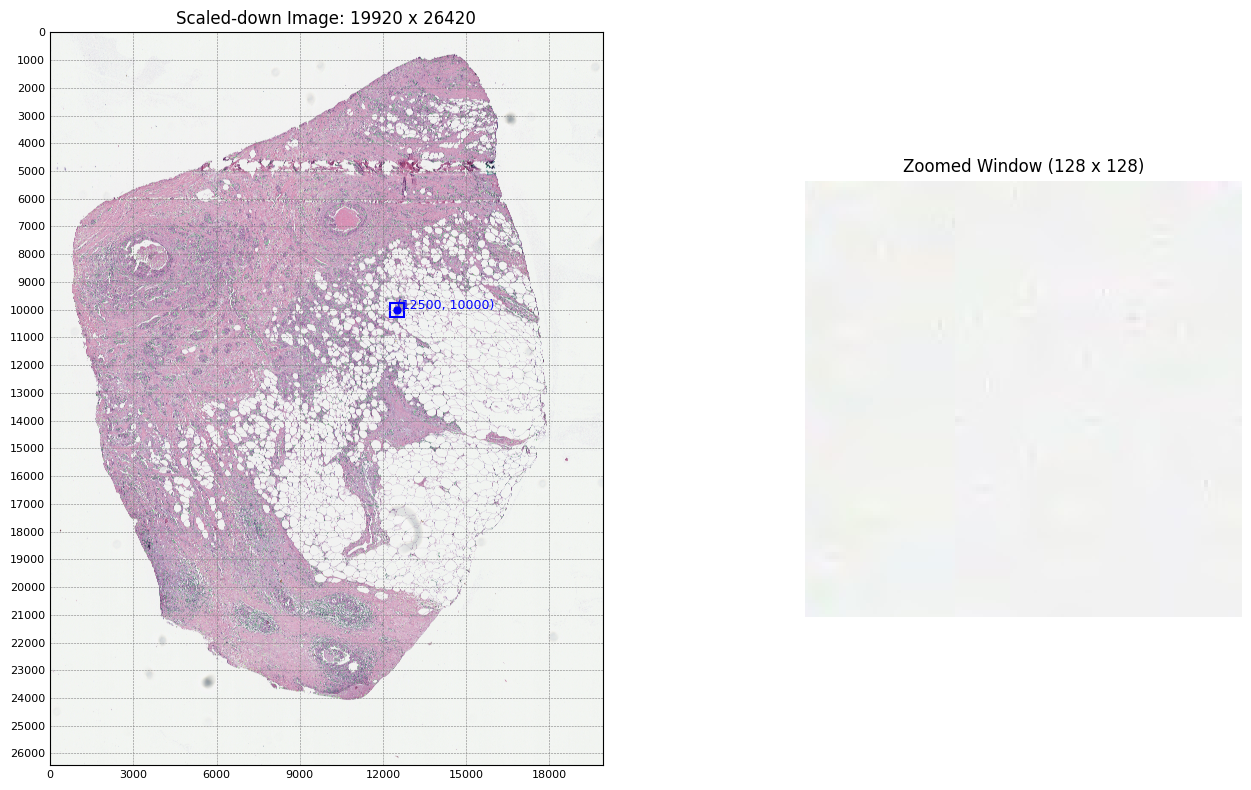


<span style="color:red"><em>
Note that the image displayed herein is a downsampled JPEG version of the original multi-gig TIFF image, 
along with the region of interest zoomed in (scaled appropriately).
</em></span>


In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image
from matplotlib.patches import Rectangle
from IPython.display import Markdown, display
from matplotlib import gridspec

# Enable large images
Image.MAX_IMAGE_PIXELS = None

display(Markdown("""
### Histopathological Whole Slide Image (WSI)

A histopathological whole slide image (WSI) is a digital version of a microscope slide that 
contains a tissue sample. It is used by pathologists to examine tissues for signs of disease, 
such as cancer. 

- ___Digitization___: Traditional glass slides are scanned using a whole slide imaging scanner to produce high-resolution digital images.
- ___High Resolution___: These images are extremely detailed, often several gigapixels in size, allowing for the examination of tissues at various magnifications.
- ___Analysis___: Pathologists examine WSIs using software to pan, zoom, and navigate through different tissue regions.
- ___Remote Access___: Digital slides enable remote consultation and sharing among specialists, improving diagnostic accuracy and collaboration.
- ___Archiving and Retrieval___: WSIs facilitate easy storage and retrieval, enhancing accessibility over physical slides.
- ___AI Applications___: The digital format allows the application of artificial intelligence and machine learning for advanced analysis, such as pattern recognition and automated diagnosis assistance.

Histopathological WSIs are transforming pathology by enhancing accessibility, enabling precise diagnosis, 
and opening up opportunities for advanced research and analysis.

**For this demo, we are going to use the following histopathological whole slide image (WSI) of a tissue 
section from a lymphoid organ such as a lymph node or tonsil.**

**It has been stained using Hematoxylin and Eosin (H&E), which is commonly used in pathology to 
differentiate cell nuclei (purple/blue) and cytoplasmic or extracellular components (pink).**

"""))

# Load image
image_path = "input/image.tif"
img = Image.open(image_path)
width, height = img.size

# ROI parameters
center_x, center_y = 12500, 10000
window_size = 128
half_window = window_size // 2
left = max(center_x - half_window, 0)
upper = max(center_y - half_window, 0)
right = min(center_x + half_window, width)
lower = min(center_y + half_window, height)
zoomed_img = img.crop((left, upper, right, lower))

# Setup: use GridSpec for custom layout
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # 3:1 ratio

# Original image (larger area)
ax1 = fig.add_subplot(gs[0])
ax1.imshow(img)
ax1.set_title(f"Scaled-down Image: {width} x {height}")

# Sparse grid
ax1.grid(True, which='major', color='gray', linestyle='--', linewidth=0.4)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3000))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax1.tick_params(axis='both', which='both', length=0, labelsize=8)
ax1.xaxis.set_minor_locator(ticker.NullLocator())
ax1.yaxis.set_minor_locator(ticker.NullLocator())

# Axis limits and ROI marker
ax1.set_xlim(0, width)
ax1.set_ylim(height, 0)
ax1.plot(center_x, center_y, marker='o', color='blue', markersize=5)
ax1.text(center_x + 10, center_y - 10, f'({center_x}, {center_y})', color='blue', fontsize=9)

# Larger rectangle for better visibility 
rectangle_size = int(window_size * 4)
rect_half = rectangle_size // 2
rect = Rectangle((center_x - rect_half, center_y - rect_half),
                 rectangle_size, rectangle_size,
                 linewidth=1.5, edgecolor='blue', facecolor='none')
ax1.add_patch(rect)

# Zoomed-in window (smaller area)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(zoomed_img, interpolation='nearest')  # 'nearest' preserves pixel sharpness
ax2.set_title(f"Zoomed Window ({window_size} x {window_size})")
ax2.axis('off')

plt.tight_layout()
plt.show()

display(Markdown("""
<span style="color:red"><em>
Note that the image displayed herein is a downsampled JPEG version of the original multi-gig TIFF image, 
along with the region of interest zoomed in (scaled appropriately).
</em></span>
"""))


## Read image & extract metadata
Read the image into memory using CuImage and leverage the rich set of APIs provided by hipCIM to examine the metadata of the image.

In [5]:
from cucim import CuImage

# Create a CuImage object from the TIFF image file
img = CuImage("input/image.tif")

# Get the size of the image file
size_h = filesize_h("input/image.tif")

# Get the dimensions in pixels  
width, height = img.size('XY')

# Debug: Check what's in raw_metadata
print("Raw metadata type:", type(img.raw_metadata))
print("Raw metadata length:", len(img.raw_metadata) if img.raw_metadata else 0)
print("First 100 characters of raw metadata:", repr(img.raw_metadata[:100]) if img.raw_metadata else "None")

# Try to extract details from raw metadata string (XML) with error handling
# try:
#     if img.raw_metadata and img.raw_metadata.strip():
#         ome_dict = xml_to_dict(ET.ElementTree(ET.fromstring(img.raw_metadata)).getroot())
#         pixel_type = ome_dict['OME']['Image']['Pixels']['@Type']
#         physical_size_x = ome_dict['OME']['Image']['Pixels']['@PhysicalSizeX']  
#         physical_size_x_unit = ome_dict['OME']['Image']['Pixels']['@PhysicalSizeXUnit'] 
#         physical_size_y = ome_dict['OME']['Image']['Pixels']['@PhysicalSizeY']  
#         physical_size_y_unit = ome_dict['OME']['Image']['Pixels']['@PhysicalSizeYUnit'] 
#         width_physical = f"{physical_size_x}{physical_size_x_unit}"
#         height_physical = f"{physical_size_y}{physical_size_y_unit}"
#     else:
#         print("Warning: No valid XML metadata found, using default values")
#         pixel_type = "Unknown"
#         width_physical = "Unknown"
#         height_physical = "Unknown"
# except (ET.ParseError, KeyError, TypeError) as e:
#     print(f"Error parsing metadata: {e}")
#     print("Using default values...")
#     pixel_type = "Unknown"
#     width_physical = "Unknown"
#     height_physical = "Unknown"

# image_metadata = f"""
# | Metadata | Value | 
# | -------- | ----- | 
# | Filename | **{img.path}** |
# | Image file size | **{size_h}** |
# | Image width | **{width}px** (**{width_physical}**) |
# | Image height | **{height}px** (**{height_physical}**) |
# | Image device | **{img.device}** |
# | Pixel type | **{pixel_type}** |
# | Number of dimensions [channels] | **{img.ndim}**  **{img.channel_names}** |
# """
# printmd(image_metadata)

Raw metadata type: <class 'str'>
Raw metadata length: 43
First 100 characters of raw metadata: '{"axes": "YXC", "shape": [26420, 19920, 3]}'


### Read region

Read and extract a specific sub-region from the much larger image file. By default, the region is loaded onto the host memory (CPU).


| Data | Image | Region |  
| ---- | ----- | ------ |
| Size | **[19920, 26420]** | **[512, 512]** | 
| Dimensions | **3** | **3** | 
| Shape | **[26420, 19920, 3]** |  **[512, 512, 3]** |

**Note**:
   - The region has `4` channels (RGBA)
   - The `slow-path` warning is due to the lack of support for Global data Share (GDS)


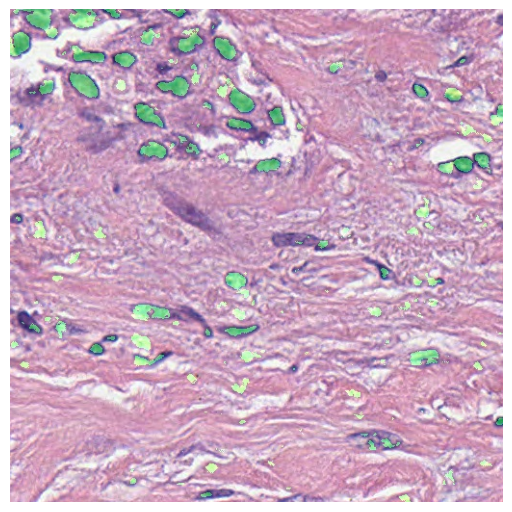

In [6]:
from cucim import CuImage

# Create a CuImage object from the TIFF image file
img = CuImage("input/image.tif")

# Read in a specific sub-region from the larger image into host (CPU) memory
region = img.read_region(location=[2500, 10000], size=(512, 512))

# Display the region along with a comparison with the original image
printmd(f"""
| Data | Image | Region |  
| ---- | ----- | ------ |
| Size | **{img.size('XYZ')}** | **{region.size('XYZ')}** | 
| Dimensions | **{img.ndim}** | **{region.ndim}** | 
| Shape | **{img.shape}** |  **{region.shape}** |

**Note**:
   - The region has `4` channels (RGBA)
   - The `slow-path` warning is due to the lack of support for Global data Share (GDS)
""")

# Display the region
visualize(region)

# Save the image using hipCIM (currently, hipCIM can save image with .ppm format)
region.save("thumbnail.ppm")

## Array interface

### `__array_interface__` support
A NumPy array has an [\_\_array_interface__](https://numpy.org/doc/stable/reference/arrays.interface.html) property, and conversely, a Python object that has an `__array_interface__` property is considered a NumPy array and can be converted to a NumPy array through the `np.asarray(obj)` method. The following example demonstrates the concept.

A CuImage object supports the `__array_interface__` property and hence can be converted to a NumPy array as demonstrated in the example below.

Image supports `__array_interface__`: **{'data': (97664672, False), 'strides': None, 'descr': [('', '|u1')], 'typestr': '|u1', 'shape': (512, 512, 3), 'version': 3}**

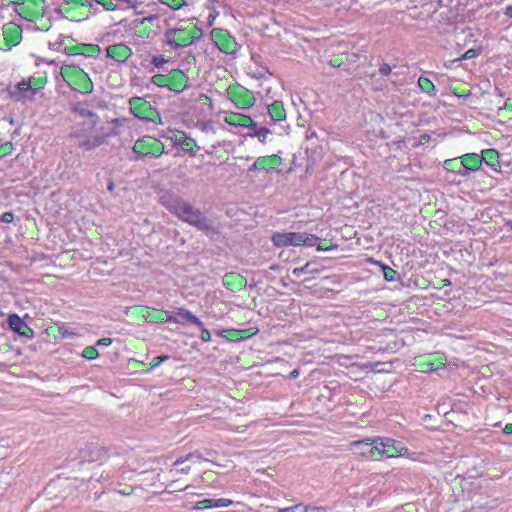

In [7]:
from cucim import CuImage
import numpy as np
from PIL import Image

# Create a CuImage object from the TIFF image file
img = CuImage("input/image.tif")

# Read in a specific sub-region from the larger image into host (CPU) memory
region = img.read_region(location=[2500, 10000], size=(512, 512))

# Convert the image to a NumPy array
np_img_arr = np.asarray(region)

# The image supports the __array_interface__ property
printmd(f"Image supports `__array_interface__`: **{region.__array_interface__}**")

# Render the array as an image using Pillow
Image.fromarray(np_img_arr) 

### `__cuda_array_interface__` support

Similarly, a CuPy array has the [\_\_cuda_array_interface__](https://numba.readthedocs.io/en/stable/cuda/cuda_array_interface.html) property, and conversely, a Python object that has the `__cuda_array_interface__` property is considered a CUDA array-like object and can be converted to CuPy array through `cp.asarray(obj)` method.

A CuImage object supports the `__cuda_array_interface__` property if the user specifies `device='cuda'` in the `read_region()` method, which implies loading the region onto the GPU. The following example demonstrates how to load an image to GPU memory and visualize in the Jupyter notebook.

cuda


[Warning] Loading image('layer7_vips.tif') with a slow-path. The pixel format of the loaded image would be RGBA (4 channels) instead of RGB!


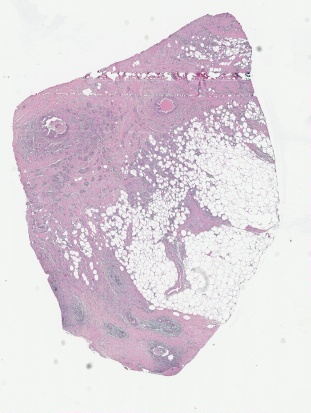

In [8]:
# sudo apt install libvips (if you haven't already)
import pyvips
from cucim import CuImage
import os
import cupy as cp
from PIL import Image

# Load the seventh layer (page 6) from the TIFF image
image = pyvips.Image.new_from_file("input/image.tif", page=6)


# Save the extracted layer as a PNG file
image.write_to_file("layer7_vips.tif")


# Load the TIFF image using CuImage
img = CuImage("layer7_vips.tif")

# Get image dimensions
width, height = img.shape[1], img.shape[0]

# Read a region from the image on the GPU
region = img.read_region([0, 0], [width, height], 0, device="cuda")
print(region.device)

# # Convert to CuPy array and then to PIL Image
cupy_arr = cp.asarray(region)
Image.fromarray(cupy_arr.get())
# pil_img = Image.fromarray(cupy_arr.get())

# # Save or display the image
# pil_img.save("region_from_tiff_gpu.png")

## Image Processing (skimage)
### Stain Separation with hipCIM's scikit-image-Compatible Filter API

Stain separation is a crucial process in the analysis of histopathological images, offering critical insights into tissue composition and function. hipCIM, with its scikit-image compatible filter API, facilitates efficient and GPU-accelerated processing of these images, enabling refined stain separation for enhanced analysis.

#### Stain Separation and Its Importance
1. Understanding Histological Stains
   - ___Hematoxylin___: Hematoxylin is a blue-purple stain that binds to nucleic acids, primarily staining cell nuclei. This makes it invaluable in highlighting cellular structures and nuclear morphology.
   - ___Eosin___: Eosin is a pink-red stain that binds to proteins, staining cytoplasmic components and connective tissue. It provides contrast to hematoxylin and helps visualize general tissue architecture.
   - ___DAB (`3,3'-Diaminobenzidine`)___: DAB is often used in immunohistochemistry, producing a brown stain upon reacting with peroxidase enzymes. It highlights specific antigen or protein locations within tissues.

2. Importance of Stain Separation
   - ___Enhanced Visualization___: By effectively separating these stains, researchers can independently evaluate the intensity and distribution of each component, gaining a more comprehensive understanding of cell and tissue structure.
   - ___Quantitative Analysis___: Stain separation allows for quantification of specific cellular or tissue features, crucial for detailed analysis in research and diagnostics.
   - ___Objective Evaluation___: It reduces subjective interpretation by providing clearer, quantifiable visual data on stained tissue sections.

3. Applications in the Life Sciences
   - ___Diagnostic Pathology___: Stain separation aids pathologists in identifying abnormalities, diagnosing diseases, and assessing conditions such as cancer by examining the distinct cellular structures highlighted by different stains.
   - ___Bio-Medical Research___: It supports research into cellular function, disease progression, and treatment efficacy by enabling precise analysis of tissue response to various conditions and treatments.
   - ___Automated Image Analysis___: Facilitating machine learning and AI applications by providing cleaner, more structured data for training models aimed at automated diagnosis or research tasks.

#### hipCIM's scikit-image-compatible filter API
The integration of hipCIM with the scikit-image-compatible filter API showcases the efficient separation of stains within histopathological images. By leveraging GPU acceleration, hipCIM enables rapid processing of large datasets, making stain separation more effective and accessible.

In this example, hipCIM’s compatibility with established image processing methodologies allows researchers to seamlessly incorporate advanced stain separation into their workflows. This not only enhances the clarity and usefulness of histological data but also ensures that these processes are scalable and robust, fitting within the time-sensitive demands of both clinical and research environments.

Through stain separation, hipCIM empowers life science professionals to unlock greater levels of insight and detail within tissue studies, facilitating breakthroughs in understanding and addressing complex biological phenomena.

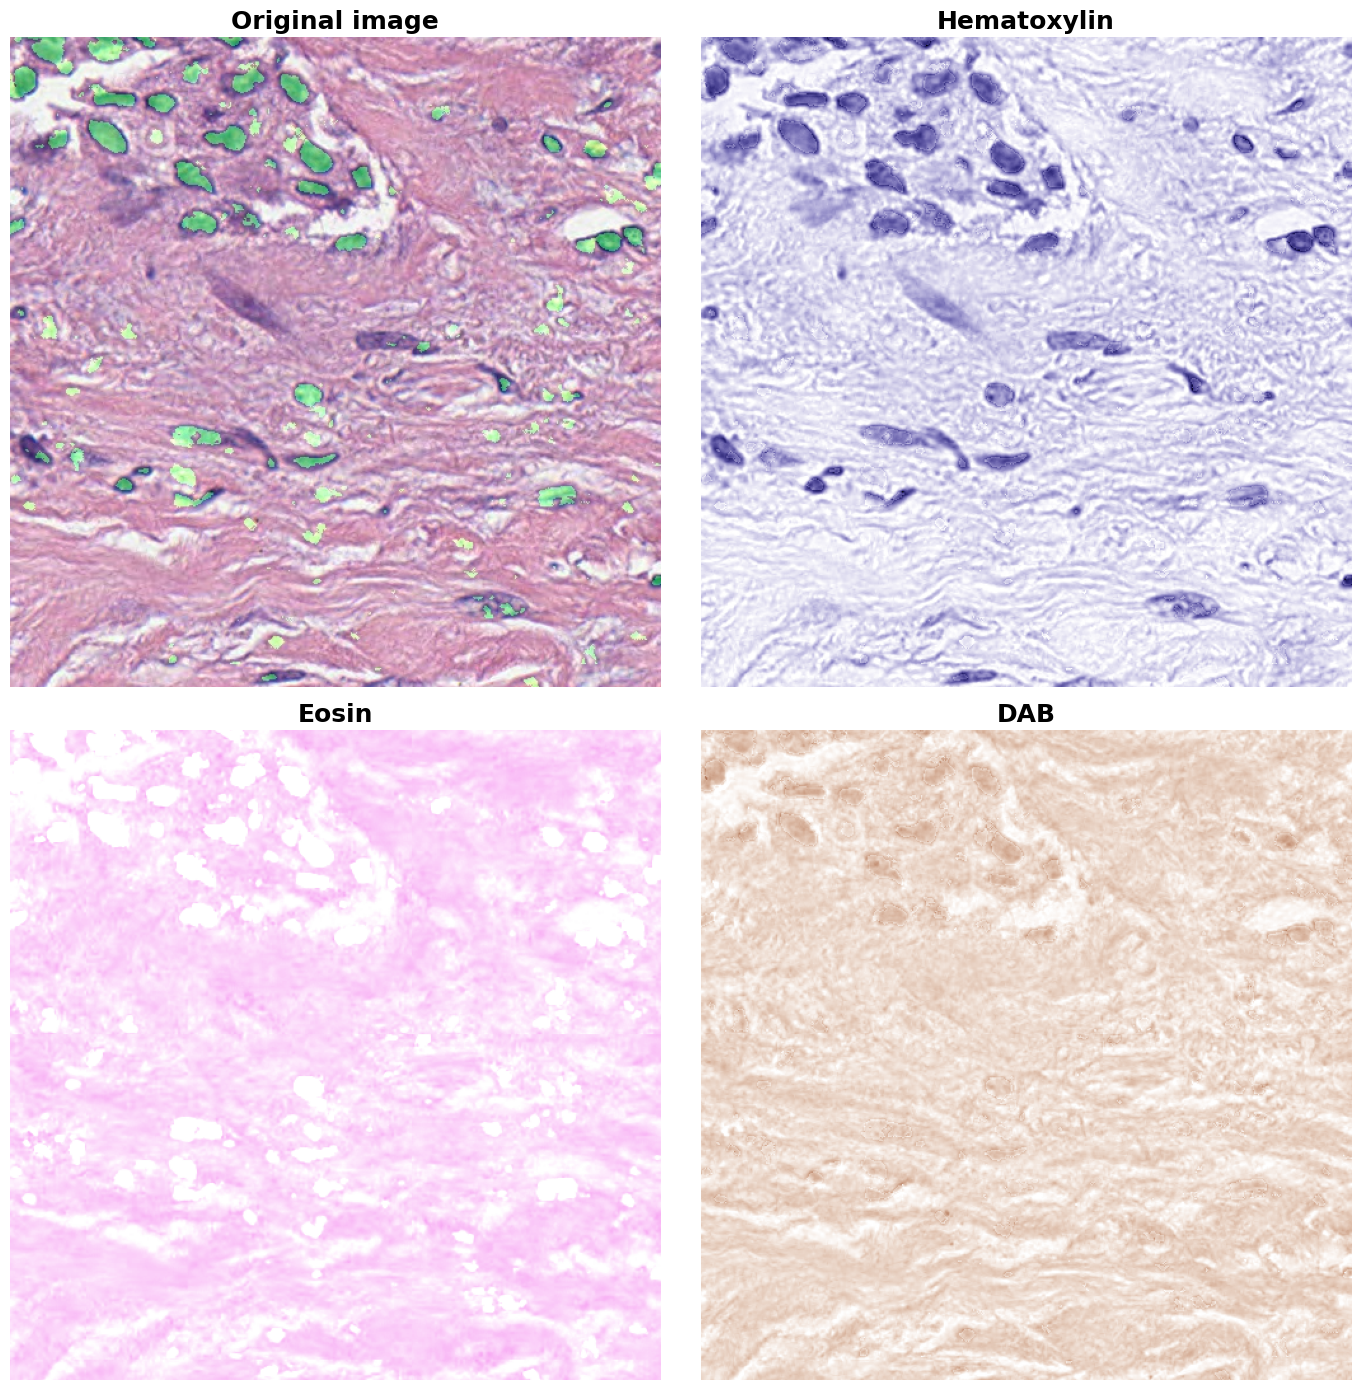

In [9]:
from cucim import CuImage
import cupy as cp
from PIL import Image
from cucim.skimage import color
from matplotlib import pyplot as plt

# Create a CuImage object from the TIFF image file
img = CuImage("input/image.tif")

# Read in a specific sub-region into host (CPU) memory
region = img.read_region(location=[2500, 10000], size=(512, 512))

# Transfer the array to the device and leverage 
# hipCIM to convert 4-channel (RGBA) regions to RGB
# ihc_rgb = color.rgba2rgb(cp.asarray(region))

# Transform to colorspace where the stains are separated
ihc_hed = color.rgb2hed(cp.asarray(region))

# Create an RGB image for visualizing each of the stains
null = cp.zeros_like(ihc_hed[:, :, 0])
ihc_h = color.hed2rgb(cp.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = color.hed2rgb(cp.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = color.hed2rgb(cp.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# Transfer each color image back to the CPU prior to visualization
ihc_h, ihc_e, ihc_d = map(cp.asnumpy, [ihc_h, ihc_e, ihc_d])

# Plot the images
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharex=True, sharey=True)
fontdict = dict(fontsize=18, fontweight='bold')
ax = axes.ravel()
ax[0].imshow(cp.asnumpy(region))
ax[0].set_title("Original image", fontdict=fontdict)
ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin", fontdict=fontdict)
ax[2].imshow(ihc_e)
ax[2].set_title("Eosin", fontdict=fontdict)
ax[3].imshow(ihc_d)
ax[3].set_title("DAB", fontdict=fontdict)
for a in ax.ravel():
    a.axis('off')
fig.tight_layout()
plt.show()

### Albumentation

[Albumentation](https://albumentations.ai/) is a widely-regarded library in the realm of image augmentation, especially within machine learning and deep learning frameworks. It offers an extensive selection of augmentation techniques designed to improve model robustness and accuracy by increasing the diversity of training datasets.

#### Image Augmentation through Albumentation

   - ___Enhancement___: Image augmentation in deep learning involves systematically altering training images to improve model generalization. Techniques such as cropping, rotating, flipping, and scaling prevent models from overfitting by creating a richer set of training inputs.
   - ___Utility___: Albumentations empowers developers to apply complex augmentations with simplicity and efficiency, aligning perfectly with the iterative, data-intensive nature of deep learning workflows.

#### Albumentation with hipCIM

___In this example, we demonstrate how to efficiently apply resizing operations using Albumentation's versatile interfaces. By integrating scikit-image methods with Albumentation's powerful augmentation workflows, users can seamlessly and rapidly adjust image resolutions suited to their application needs.___

This approach offers life science researchers and machine learning practitioners a scalable solution for preprocessing large image datasets, catering to model training requirements and analytical needs. The ease of executing such transformations underscores Albumentation's value in optimizing and expanding the capabilities of image-centric deep learning projects.

#### Reading and Resize Image with Albumentation's Compose method

The following example illustrates the interoparability of hipCIM with the Albumentation workflow, defining a `Resize` operation that inherits the `ImageOnlyTransform` class.
   - ___ImageOnlyTransform___: The [ImageOnlyTransform](https://albumentations.ai/docs/api_reference/core/transforms_interface/#albumentations.core.transforms_interface.ImageOnlyTransform) interface is ideal for operations where the transformation is exclusively applied to image data, allowing flexibility and precision in modifications without influencing other dataset attributes like labels or metadata.
   - ___Compose Method___: [Compose](https://albumentations.ai/docs/api_reference/core/composition/#albumentations.core.composition.Compose) enables chaining multiple transformations to apply sequentially, streamlining and automating the augmentation process while ensuring coherence and efficiency across modifications.

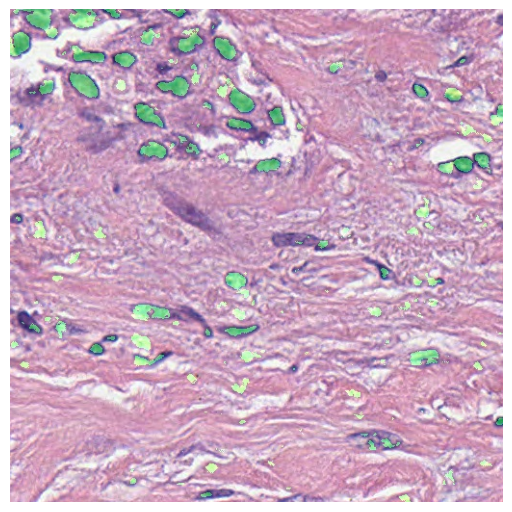

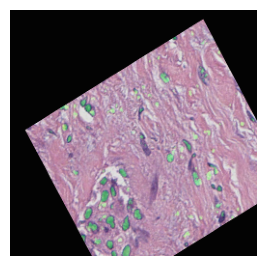

In [10]:
from cucim import CuImage
from cucim.skimage.util import img_as_ubyte 
from cucim.skimage.transform import resize
from albumentations.core.transforms_interface import ImageOnlyTransform  
from albumentations import Compose, RandomRotate90, Affine, Resize, RandomBrightnessContrast, GaussianBlur, Rotate
import numpy as np

class Resize(ImageOnlyTransform):  
    def __init__(self, height, width, order=1, mode='reflect', cval=0, clip=True, preserve_range=False, anti_aliasing=True,  
                 anti_aliasing_sigma=None, always_apply=True, p=1.0):  
        super().__init__(always_apply, p)  # 'p' probability of applying the transformation, typically used in augmentation scenarios
        self.height = height  
        self.width = width  
        self.order = order  # interpolation order, which determines the way pixel values are calculated in the resized image
        self.mode = mode    # how to handle borders of the image, with 'reflect' referring to mirroring the edge pixels
        self.cval = cval    # constant value used for padding when mode is set to 'constant'
        self.clip = clip    # whether pixel values should be clipped to stay within the range
        self.preserve_range = preserve_range  # when True, pixel values are not rescaled
        self.anti_aliasing = anti_aliasing    # boolean indicating whether to apply anti-aliasing, which helps to reduce distortion
        self.anti_aliasing_sigma = anti_aliasing_sigma  # standard deviation for Gaussian smoothing when anti_aliasing is applied

    # GPU accelerated resizing
    def apply(self, img, **params):  
        # Ensure that the input image is converted to a compatible format and apply resizing  
        resized_image = img_as_ubyte(  
            resize(  
                cp.asarray(img),  
                (self.height, self.width),  
                order=self.order,  
                mode=self.mode,  
                cval=self.cval,  
                clip=self.clip,  
                preserve_range=self.preserve_range,  
                anti_aliasing=self.anti_aliasing,  
                anti_aliasing_sigma=self.anti_aliasing_sigma  
            )  
        ).get()  
        return resized_image  

# Use the Albumentations Compose to apply a sequence of image transformations which in this case 
# is a single Resize transformation. The Compose object sequentially applies the transformations 
# to the input data.
transform = Compose([  
    Resize(256, 256), # Resize to 256x256
    RandomRotate90(p=0.7), # Randomly rotate by 90 degrees with 70% probability
    Affine(p=0.8, scale=0.8, shear=4, translate_percent=0.1, rotate=30), # Geometric transformations like scaling, rotation, & translation
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),  # Adjust brightness and contrast
    GaussianBlur(blur_limit=7, p=0.3),  # Apply Gaussian blur with 30% probability
    Rotate(limit=45, p=0.7),  # Rotate image up to 45 degrees
])  

# Create a CuImage object from the TIFF image file
img = CuImage("input/image.tif")

# Read in a specific sub-region into host (CPU) memory
region = img.read_region(location=[2500, 10000], size=(512, 512))

# Convert the region into a NumPy array
image = np.asarray(region)  
visualize(image)

# Resize the image using the accelerated transformation
augmented_image = transform(image=image)['image']    
visualize(augmented_image) 

### Gabor Filters

In this demonstration, we explore the use of Gabor filters on tissue and some sample images, showcasing both original and processed versions, while highlighting the value of GPU acceleration over CPU execution.

##### ___Introduction___

<img src="static_images/Gabor_filters_snippet.jpg" style="float: right; width: 300px" alt="Example of Gabor filter responses">

Gabor filters play a crucial role in image processing, particularly for texture analysis and feature extraction. By creating a Gabor kernel with parameters such as sigma (Gaussian envelope size), theta (orientation), lambda (wavelength), psi (phase offset), and gamma (aspect ratio), we enhance image textures through convolution with a grayscale image.

This technique emphasizes features that are subtle in the original image, making hidden textures more visible by highlighting orientational and frequency-specific patterns.

In the original image, individual cells and tissue structures are visible, allowing for a visual inspection of morphology. The Gabor filter enhances this by bringing out specific textures that align with particular features or patterns, capturing edges and repetitive structures efficiently.

##### ___Applications in Life Sciences___

Gabor filters are invaluable in the life sciences for several reasons:

   - *Feature Enhancement*: They unveil cellular and tissue patterns not immediately apparent, aiding in differentiating tissue types and identifying abnormalities.
   - *Machine Learning and Automation*: By highlighting specific features, Gabor-filtered images serve as rich datasets for machine learning models that classify tissue types or detect pathological changes, reducing dependence on manual assessments.
   - *Comprehensive Analysis*: Observing textures at multiple orientations offers a multifaceted view of a sample’s textural properties, assisting in the diagnosis and understanding of tissue morphology and pathology.
   - *Research and Development*: They are pivotal in developing targeted therapies and understanding disease mechanisms through high-resolution imaging combined with computational analysis.

In summary, Gabor filters help transform ordinary tissue images into detailed maps of hidden structures, facilitating advancements in diagnostics and research.

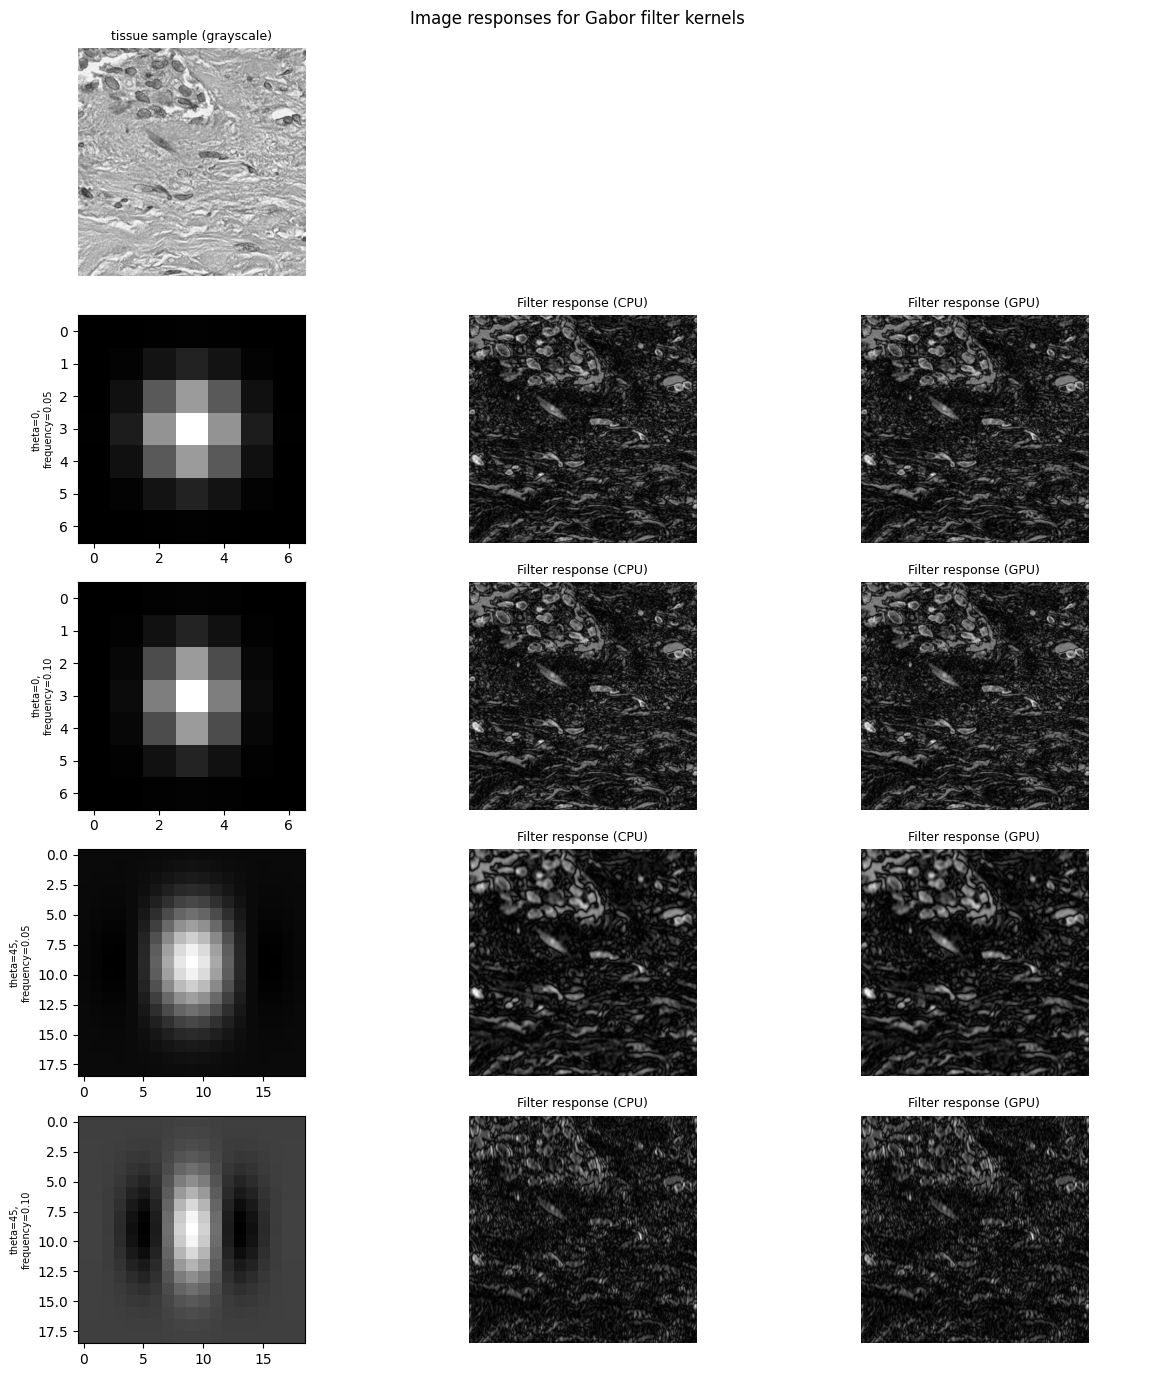

Duration (CPU) = **0.8388714790344238s**

Duration (GPU) = **0.2951853275299072s**

**GPU Acceleration = 2.8418**

In [11]:
from cucim import CuImage
from matplotlib import pyplot as plt
import time

# Create a CuImage object from the TIFF image file
img = CuImage("input/image.tif")

# Read in a specific sub-region into host (CPU) memory
region = img.read_region(location=[2500, 10000], size=(512, 512))

durations = {}
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 14))
fig.suptitle(f"Image responses for Gabor filter kernels", fontsize=12)

for use_gpu in (False, True):
    # Creates separate namespaces (xp and asnumpy) for 
    # NumPy and CuPy operations, respectively
    if use_gpu:
        from cupyx.scipy import ndimage as ndi
        from cucim.skimage.util import img_as_float32
        from cucim.skimage.filters import gabor_kernel
        import cupy as cp
        xp = cp
        asnumpy = cp.asnumpy
        device_name = "GPU"
        colidx = 2
    else:
        from scipy import ndimage as ndi
        from skimage.util import img_as_float32
        from skimage.filters import gabor_kernel
        import numpy as np
        xp = np
        asnumpy = np.asarray
        device_name = "CPU"
        colidx = 1
  
    # Apply a set of Gabor filters (kernels) to an image and 
    # compute the mean and variance of the filtered image, 
    # storing them as features
    def compute_feats(image, kernels):
        feats = xp.zeros((len(kernels), 2), dtype=np.double)
        for k, kernel in enumerate(kernels):
            filtered = ndi.convolve(image, kernel, mode='wrap')
            feats[k, 0] = filtered.mean()
            feats[k, 1] = filtered.var()
        return feats

    def power(image, kernel):
        # Normalize images for better comparison.
        image = (image - image.mean()) / image.std()
        return xp.sqrt(ndi.convolve(image, kernel.real, mode='wrap')**2 +
                       ndi.convolve(image, kernel.imag, mode='wrap')**2)
    
    # Track timing
    tstart = time.time()
    
    # Create a grayscale image from the original tissue image,
    # similar to the above sample images 
    tissue = img_as_float32(xp.asarray(region))
    tissue = tissue[..., :3].mean(axis=-1)
    
    # List of all images to be used along with labels
    image_names = ['tissue']
    images = [tissue]

    # Prepare Gabor filter bank kernels varying in orientation (theta),
    # frequency, and size (sigma), used to extract features from images 
    # sigma: Controls the width of the Gaussian envelope. A larger 
    #        sigma will result in more smoothing; smaller details 
    #        may be suppressed, emphasizing larger structures.
    # theta: Defines the orientation of the Gabor filter; helps in 
    #        detecting features oriented in different directions.
    # lambda: Determines the frequency of the sinusoidal wave. A 
    #         smaller lambda emphasizes finer textures, while a 
    #         larger lambda highlights coarser patterns.
    # psi: Changing psi can shift the sinusoidal component along 
    #      the spatial domain, which might reveal different 
    #      features depending on the phase shift.
    # gamma: Controls the ellipticity of the Gaussian. A gamma less 
    #        than 1 creates elongated filters, which might be useful 
    #        for emphasizing features that appear more linear at 
    #        certain orientations.
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.1):
                kernel = gabor_kernel(frequency, theta=theta,
                                      sigma_x=sigma, sigma_y=sigma)
                kernels.append(kernel.real)

    # Prepare reference features
    ref_feats = xp.zeros((1, len(kernels), 2), dtype=np.double)
    ref_feats[0, :, :] = compute_feats(tissue, kernels)

    # Plot the original images, Gabor filter kernels, and the power 
    # images resulting from these kernel applications
    results = []
    kernel_params = []
    params = [(theta / 4. * np.pi, frequency)   
              for theta in range(4)  
              for frequency in (0.05, 0.1)]  
    for (theta, frequency), kernel in zip(params, kernels):  
        param_str = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)  
        kernel_params.append(param_str)  
        results.append((kernel, xp.stack([power(img, kernel) for img in images])))  
    
    # Track time
    dur = time.time() - tstart
    durations[device_name] = dur

    # Plot the original image
    axes[0][0].imshow(asnumpy(tissue), cmap='gray')
    axes[0][0].set_title("tissue sample (grayscale)", fontsize=9)
    axes[0][0].axis('off')
    axes[0][colidx].axis('off')

    # For each kernel, plot the responses
    for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
        # Plot Gabor kernel in the first subplot of each row
        ax_row[0].imshow(asnumpy(kernel.real), cmap='gray')
        ax_row[0].set_ylabel(label, fontsize=7)

        # Plot Gabor responses with the contrast normalized for each filter
        vmin = float(powers.min())
        vmax = float(powers.max())
        ax_row[colidx].imshow(asnumpy(powers[0]), vmin=vmin, vmax=vmax, cmap='gray')
        ax_row[colidx].axis('off')
        ax_row[colidx].set_title(f"Filter response ({device_name})", fontsize=9)
    
plt.gray()
plt.tight_layout()
plt.show()

# Display duration & comparison
printmd(f"Duration (CPU) = **{durations['CPU']}s**")
printmd(f"Duration (GPU) = **{durations['GPU']}s**")
printmd(f"**GPU Acceleration = {durations['CPU']/durations['GPU']:0.4f}**")

### Segmentation Example

**The ability to segment and analyze histopathological images is a cornerstone of research and diagnostics in the life sciences. This example highlights how hipCIM efficiently performs these operations, leveraging the power of GPU acceleration on AMD Instinct GPUs.**

The process is divided into key steps:
   - ___Tissue Segmentation___
      - Image segmentation involves partitioning an image into distinct regions, typically based on characteristics like color intensity. This allows for isolating areas of interest—such as different tissue types—in histopathological images.
      - Segmenting tissue assists pathologists in identifying and classifying various cell structures and anomalies, aiding in disease diagnosis and understanding tissue morphology.
   - ___Edge Detection with Sobel Filter___
        - The Sobel filter, a gradient-based method, is a popular edge detection technique that calculates intensity gradients within an image. This highlights the edges by emphasizing transitions between different tissue structures.
        - Detecting edges helps in delineating boundaries within tissue samples, making it easier to recognize distinct components such as cellular membranes, tissue boundaries, or pathological structures.

In this demonstration, we perform these operations on a histopathological image using both CPU and GPU processing to emphasize the advantages of GPU acceleration
1. ___Grayscale Conversion and Segmentation___
   The image is converted to grayscale to simplify analysis, focusing on intensity rather than color. Using a set threshold, tissue regions are segmented, revealing areas of biological interest that differ in staining intensity.
2. ___Edge Detection___
   By applying the Sobel filter, edges within the sample are highlighted, showcasing structural transitions that are critical in understanding tissue architecture or identifying pathological changes.
3. ___Performance Comparison___
   The script measures the time taken for both GPU and CPU processing, clearly demonstrating the performance enhancements provided by GPU acceleration. This speedup is crucial when dealing with large datasets typical in life sciences, where rapid analysis can expedite research and diagnostic workflows.

The script iterates over two configurations: with and without GPU acceleration. For the GPU path, `cupyx.scipy.ndimage` is used, while the CPU path utilizes `scipy.ndimage`. The original image, its segmented version, and the result of edge detection are displayed side-by-side, with execution time logged for comparative analysis. 

Overall, the integration of these image processing operations aids researchers and clinicians in extracting meaningful insights from complex biological data, enhancing both the speed and accuracy of their analyses. The use of hipCIM in this context exemplifies the growing importance of computational tools in transforming life science disciplines. Additionally, the substantial performance improvements provided by GPU processing are highlighted, underscoring hipCIM's capability in handling computationally intensive image processing tasks.

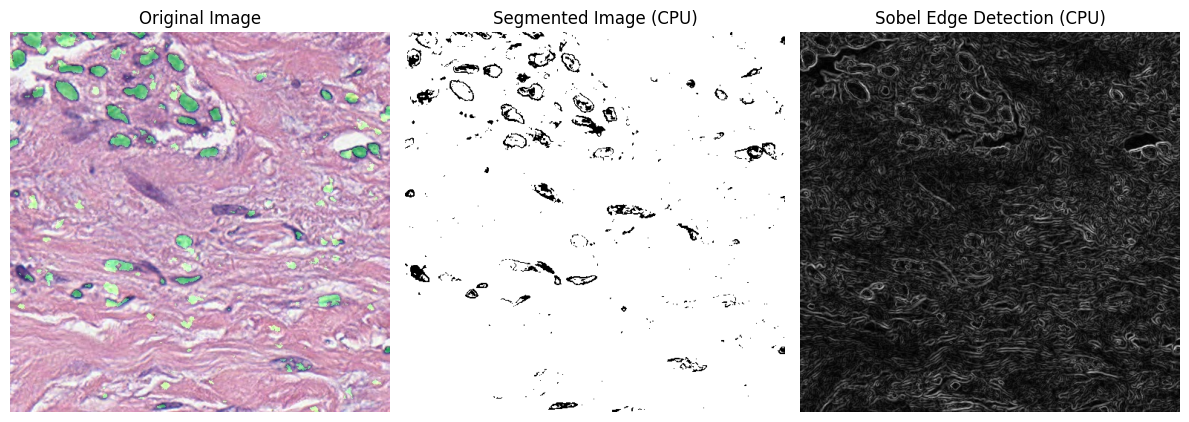

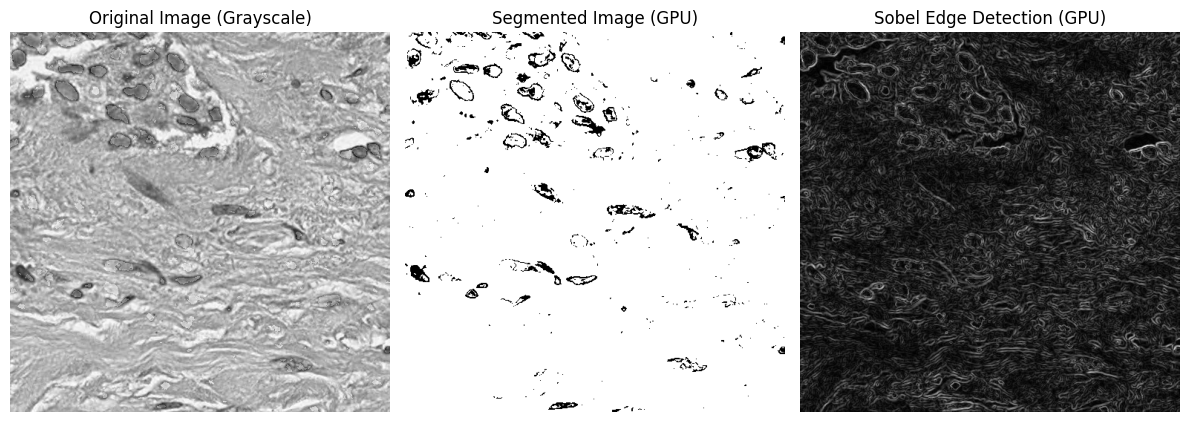

Duration (CPU) = **0.03750324249267578s**

Duration (GPU) = **1.5376551151275635s**

**GPU Acceleration = 0.0244**

In [12]:
from cucim import CuImage
from matplotlib import pyplot as plt
import time

# Create a CuImage object from the TIFF image file
img = CuImage("input/image.tif")

# Read in a specific sub-region into host (CPU) memory
region = img.read_region(location=[2500, 10000], size=(512, 512))

durations = {}  
for use_gpu in (False, True):  
    if use_gpu:  
        from cupyx.scipy.ndimage import sobel
        import cupy as cp
        asnumpy = cp.asnumpy  
        xp = cp  
        device_name = 'GPU'  
    else:  
        from scipy.ndimage import sobel
        import numpy as np
        asnumpy = np.asarray  
        xp = np  
        device_name = 'CPU'  
  
    # Track timing
    tstart = time.time()

    # Convert the image to a numpy array  
    img_array = xp.array(region)  
  
    # Convert to grayscale for simplicity  
    gray_img = xp.mean(img_array, axis=2)  
  
    # Apply a simple thresholding technique to segment the image  
    # This can be adjusted based on your specific image needs  
    threshold_value = 128  # Modify as needed  
    segmented = gray_img > threshold_value  
  
    # Apply Sobel filter to detect edges
    # Iterate a couple of time to warmup
    for i in range(5):
        sobel_x = sobel(gray_img, axis=0)  
        sobel_y = sobel(gray_img, axis=1)  
        sobel_edges = xp.sqrt(sobel_x**2 + sobel_y**2)  
  
    # Track timing
    dur = time.time() - tstart
    durations[device_name] = dur
    
    # Display the original and segmented images  
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))  

    # First column shows the original and grayscale images
    if use_gpu:  
        axes[0].imshow(asnumpy(gray_img), cmap='gray')
        axes[0].set_title('Original Image (Grayscale)')  
        axes[0].axis('off')  
    else:  
        axes[0].imshow(asnumpy(img_array))
        axes[0].set_title('Original Image')  
        axes[0].axis('off')

    # Remaining columns display the segmented images
    axes[1].imshow(asnumpy(segmented), cmap='gray')  
    axes[1].set_title(f'Segmented Image ({device_name})')
    axes[1].axis('off')

    axes[2].imshow(asnumpy(sobel_edges), cmap='gray')
    axes[2].set_title(f'Sobel Edge Detection ({device_name})')
    axes[2].axis('off')

    fig.tight_layout()
    plt.show()

printmd(f"Duration (CPU) = **{durations['CPU']}s**")
printmd(f"Duration (GPU) = **{durations['GPU']}s**")
printmd(f"**GPU Acceleration = {durations['CPU']/durations['GPU']:0.4f}**")

# Closing Summary

## Introduction to hipCIM

In this presentation, we explored the robust capabilities of hipCIM, an API-compatible replacement for CuCIM that is specifically optimized for AMD Instinct GPUs. As an open-source platform, hipCIM accelerates computer vision and image processing across multidimensional datasets, crucially supporting fields such as biomedical research, geospatial studies, and remote sensing.

## Efficient Image Handling and Adaptability

- ___Image Loading and Metadata Inspection___: We demonstrated how hipCIM uses CuImage to efficiently load high-dimensional images and inspect their metadata. This functionality is adaptable for both CPU and GPU environments, providing flexibility in data handling.
- ___Sub-Region Extraction___: Showcased the ability to extract targeted sub-regions from larger images, ensuring precise analysis capabilities.
- ___Array Interoperability___: Highlighted how CuImage objects seamlessly convert into NumPy arrays or interface directly with GPU memory, underscoring hipCIM’s adaptability across different workflows and ecosystems.

## Advanced Image Processing Techniques

- ___Stain Separation and Image Resizing___: We employed a scikit-image-compatible filter API for stain separation and leveraged the ImageOnlyTransform interface from Albumentations for image resizing. These techniques demonstrated hipCIM's interoperability and its ease of integration with existing workflows, facilitating efficient image manipulations.

## Enhanced Image Feature Extraction

- ___Gabor Filters and Edge Detection___: Applied Gabor filters for detailed texture analysis and the Sobel filter for effective edge detection, both showing enhanced feature extraction capabilities through GPU acceleration.
- ___GPU-Accelerated Image Segmentation___: Successfully demonstrated efficient segmentation based on color intensity, highlighting the speed and scalability benefits of leveraging AMD hardware.

## Conclusion

___Overall, hipCIM empowers developers by offering a versatile platform that bridges hardware ecosystems. It promotes flexibility and efficiency in deploying sophisticated image processing applications. Through this demonstration, we have shown how hipCIM can transform and elevate image analysis capabilities, setting a new benchmark for performance and versatility in multidimensional image processing.___ 